In [1]:
import os
os.chdir("./..")
os.getcwd()

'/home/carlos/Documentos/proyectos/breast_cancer'

In [2]:
import yaml
import torch
import matplotlib.pyplot as plt

In [3]:
from src.utils.models import load_pretrained_model
from src.utils.models import init_segmentation_model
from src.utils.visualization import plot_overlapping
from src.dataset.BUSI_dataloader import BUSI_dataloader

In [4]:
def plot_filter_correlations(filters):
    n_filters, n_channels, height, width = filters.shape
    corr_matrix = np.zeros((n_filters, n_filters))
    
    for i in range(n_filters):
        for j in range(n_filters):
            corr = np.corrcoef(filters[i].ravel(), filters[j].ravel())[0, 1]
            corr_matrix[i, j] = np.abs(corr)
            
    fig, ax = plt.subplots(figsize=(21, 21))
    im = ax.imshow(corr_matrix, cmap='Reds')
    ax.set_xticks(np.arange(n_filters))
    ax.set_yticks(np.arange(n_filters))
    ax.set_xticklabels(np.arange(n_filters))
    ax.set_yticklabels(np.arange(n_filters))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    for i in range(n_filters):
        for j in range(n_filters):
            text = ax.text(j, i, round(corr_matrix[i, j],2),
                           ha="center", va="center", color="w")
    ax.set_title("Filter Correlations")
    fig.colorbar(im)
    plt.show()
    
    
def plot_correlations(filters):
    
    fig = plt.Figure(figsize=(8, 8))
    # calculate the correlation matrix using numpy.corrcoef()
    corr_matrix = np.corrcoef(filters.reshape(filters.shape[0], -1))

    # plot the correlation matrix using matplotlib
    plt.imshow(np.abs(corr_matrix), cmap='coolwarm')
    plt.colorbar()
    plt.title('Pairwise Correlation of Filters', fontsize=16)
    plt.show()

In [5]:
def dice_score_from_numpy(gt, seg) -> float:
    gt = gt.astype(float)
    seg = seg.astype(float)
    
    tp = np.sum(np.logical_and(seg, gt)).astype(float)
    tn = np.sum(np.logical_and(np.logical_not(seg), gt)).astype(float)
    fp = np.sum(np.logical_and(seg, np.logical_not(gt))).astype(float)
    fn = np.sum(np.logical_and(np.logical_not(seg), gt)).astype(float)

    if np.sum(gt) == 0:
        dice = 1 if np.sum(seg) == 0 else 0
    else:
        dice = 2 * tp / (2 * tp + fp + fn)

    return dice

In [6]:
experiment_path = './runs/20230515_034323/'

if torch.cuda.is_available():
    dev = "cuda:0"
    print("GPU will be used to train the model")
else:
    dev = "cpu"
    print("CPU will be used to train the model")

GPU will be used to train the model


In [7]:
with open(f'{experiment_path}/config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

config_model = config['model']
config_training = config['training']
config_data = config['data']

In [31]:
model = init_segmentation_model(architecture=config_model['architecture'],
                                sequences=config_model['sequences'],
                                width=config_model['width'],
                                deep_supervision=config_model['deep_supervision'],
                                save_folder=None).to(dev)

model = load_pretrained_model(model, f'{experiment_path}fold_0/model_20230515_034323_fold_0')

2023-05-15 10:21:06,492 - Creating FSB_BTS_UNet_ model
2023-05-15 10:21:06,493 - The model will be fed with 1 sequences
2023-05-15 10:21:06,521 - FSB_BTS_UNet_(
  (encoder1): LevelBlock(
    (ConvInNormLRelu1): ConvInNormLeReLU(
      (Conv): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (InNorm): InstanceNorm2d(12, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (LeReLU): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (ConvInNormLRelu2): ConvInNormLeReLU(
      (Conv): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (InNorm): InstanceNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (LeReLU): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (encoder2): LevelBlock(
    (ConvInNormLRelu1): ConvInNormLeReLU(
      (Conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (InNorm): InstanceNorm2d(24, eps=1e-05, 

2023-05-15 10:21:06,522 - Total number of trainable parameters: 4626200
2023-05-15 10:21:06,559 - Loaded checkpoint './runs/20230515_034323/fold_0/model_20230515_034323_fold_0'. Last epoch: 166


In [32]:
training_loader, validation_loader, test_loader = BUSI_dataloader(seed=config_training['seed'],
                                                                  batch_size=config_data['batch_size'],
                                                                  transforms=None,
                                                                  train_size=config_data['train_size'],
                                                                  augmentations=config_data['augmentation'],
                                                                  normalization=None,
                                                                  classes=config_data['classes'],
                                                                  path_images=config_data['input_img'])


2023-05-15 10:21:12,264 - Images are contained in the following path: /home/carlos/Documentos/proyectos/breast_cancer/Datasets/Dataset_BUSI_with_GT_postprocessed_128_uniques
2023-05-15 10:21:12,269 -      Unnamed: 0                                           img_path                                          mask_path      class   id  ...  y_min  x_max  x_min  y_size  x_size
114         114  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...     benign  184  ...     22    126     27      28      99
282         282  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  malignant   84  ...     41    109     50      49      59
99           99  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...     benign  168  ...     42     80     41      26      39
180         180  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with

2023-05-15 10:21:12,273 -      Unnamed: 0                                           img_path                                          mask_path      class   id  ...  y_min  x_max  x_min  y_size  x_size
351         351  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  malignant  176  ...      9     67     11      54      56
239         239  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  malignant   30  ...      7     93     18      98      75
288         288  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  malignant   91  ...     13    104     34      62      70
261         261  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  malignant   57  ...      9    125     58      47      67
155         155  ./Datasets/Dataset_BUSI_with_GT_postprocessed_...  ./Datasets/Dataset_BUSI_wi

In [106]:
sample = next(iter(test_loader))
img = sample['image'].to(dev)
mask = sample['mask'].numpy()[0, 0, :, :]
print(img.shape)
print(mask.shape)

torch.Size([1, 1, 128, 128])
(128, 128)


In [107]:
sample

{'patient_id': tensor([176]),
 'label': tensor([[1.]]),
 'class': ['malignant'],
 'image': tensor([[[[182., 205., 204.,  ..., 168.,   1.,   0.],
           [204., 199., 204.,  ..., 193., 147.,   0.],
           [  5.,   1.,   0.,  ..., 140., 123.,   1.],
           ...,
           [  1.,   1.,   1.,  ...,   1.,   1.,   1.],
           [  1.,   1.,   1.,  ...,   1.,   1.,   1.],
           [  1.,   1.,   1.,  ...,   1.,   1.,   1.]]]]),
 'mask': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'dim1': tensor([128]),
 'dim2': tensor([128]),
 'tumor_pixels': tensor([1752])}

In [108]:
seg = model(img)
print(seg[-1].shape)

torch.Size([1, 1, 128, 128])


In [116]:
img = img.detach().cpu().numpy()[0, 0, :, :]
feat_map = torch.sigmoid(seg[-1]).detach().cpu().numpy()[0, 0, :, :]
out_npl4 = torch.sigmoid(seg[-2]).detach().cpu().numpy()[0, 0, :, :]
input1 = torch.sigmoid(seg[-3]).detach().cpu().numpy()[0, 0, :, :]
out_npl2 = torch.sigmoid(seg[-4]).detach().cpu().numpy()[0, 0, :, :]
out_npl1 = torch.sigmoid(seg[-5]).detach().cpu().numpy()[0, 0, :, :]
output2 = torch.sigmoid(seg[-6]).detach().cpu().numpy()[0, 0, :, :]
output3 = torch.sigmoid(seg[-7]).detach().cpu().numpy()[0, 0, :, :]

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

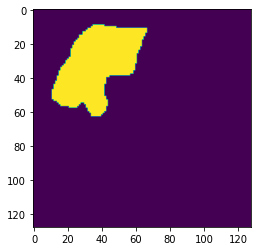

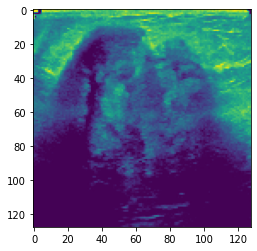

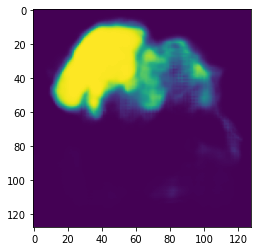

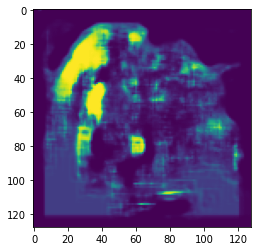

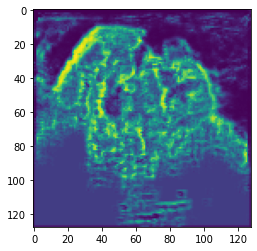

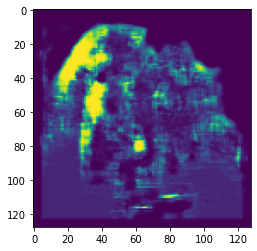

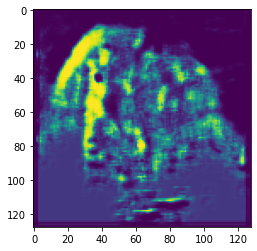

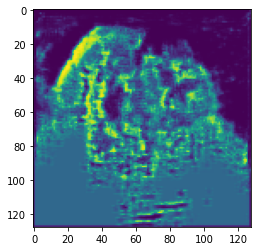

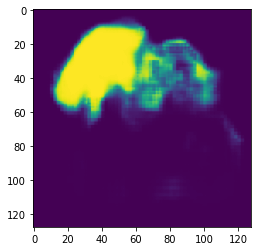

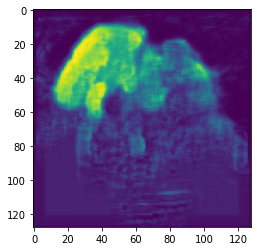

In [120]:
for i in [mask, img, feat_map, out_npl4, input1, out_npl2, out_npl1, output2, output3, 
          np.sum([feat_map, out_npl4, input1, output3], axis=0) ]:
    plt.imshow(i)
    plt.show()

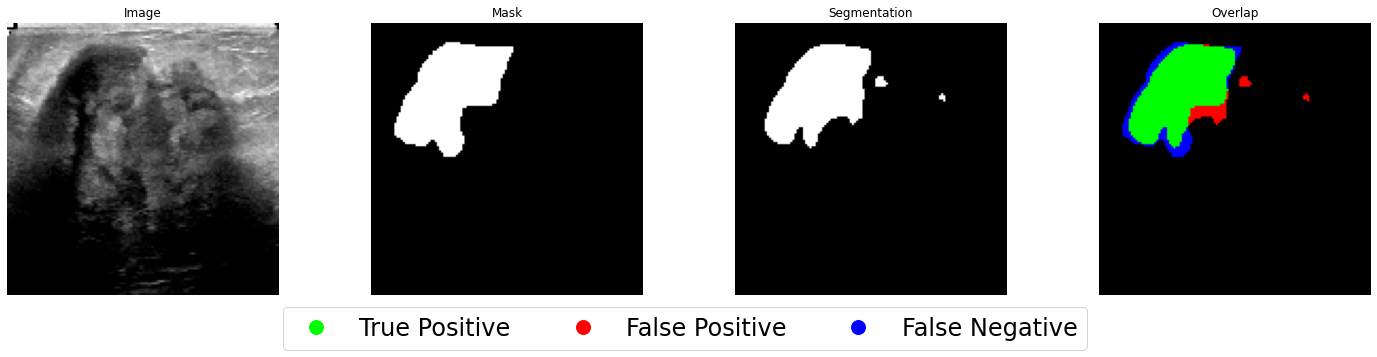

In [67]:
plot_overlapping(img, mask, feat_map > 0.8)

In [68]:
dices = [dice_score_from_numpy(mask, feat_map > t) for t in np.arange(.01, 1, .01)]
max_idx = dices.index(max(dices))
print("max dice:", max(dices))
print("0.5 threshold dice:", dices[49])

max dice: 0.8653960690887433
0.5 threshold dice: 0.7725856697819314


# Model interpretability

## Visualizing the activations

### Encoder 1

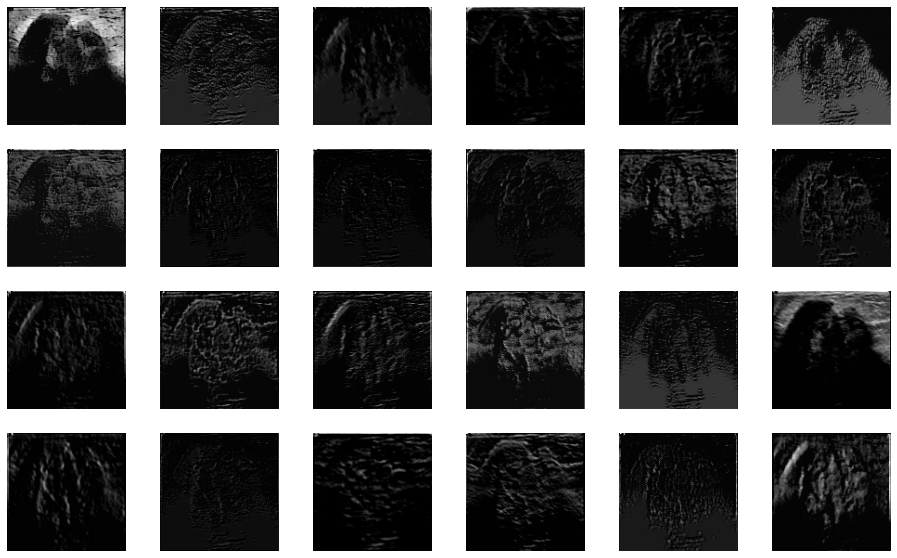

In [69]:
# Define the input image
sample = next(iter(test_loader))
input_image = sample['image'].to(dev)

# Get the activations of the first convolutional layer
activations = model.encoder1(input_image)

# Convert the activations to a numpy array
activations = activations.detach().cpu().numpy()

# Visualize the activations
fig, axs = plt.subplots(4, 6, figsize=(16, 10))
for i in range(4):
    for j in range(6):
        axs[i, j].imshow(activations[0, i*6+j, :, :], cmap='gray')
        axs[i, j].axis('off')

# plt.subplots_adjust(wspace=-0.5, hspace=-0.5)
plt.show()

### Encoder 2

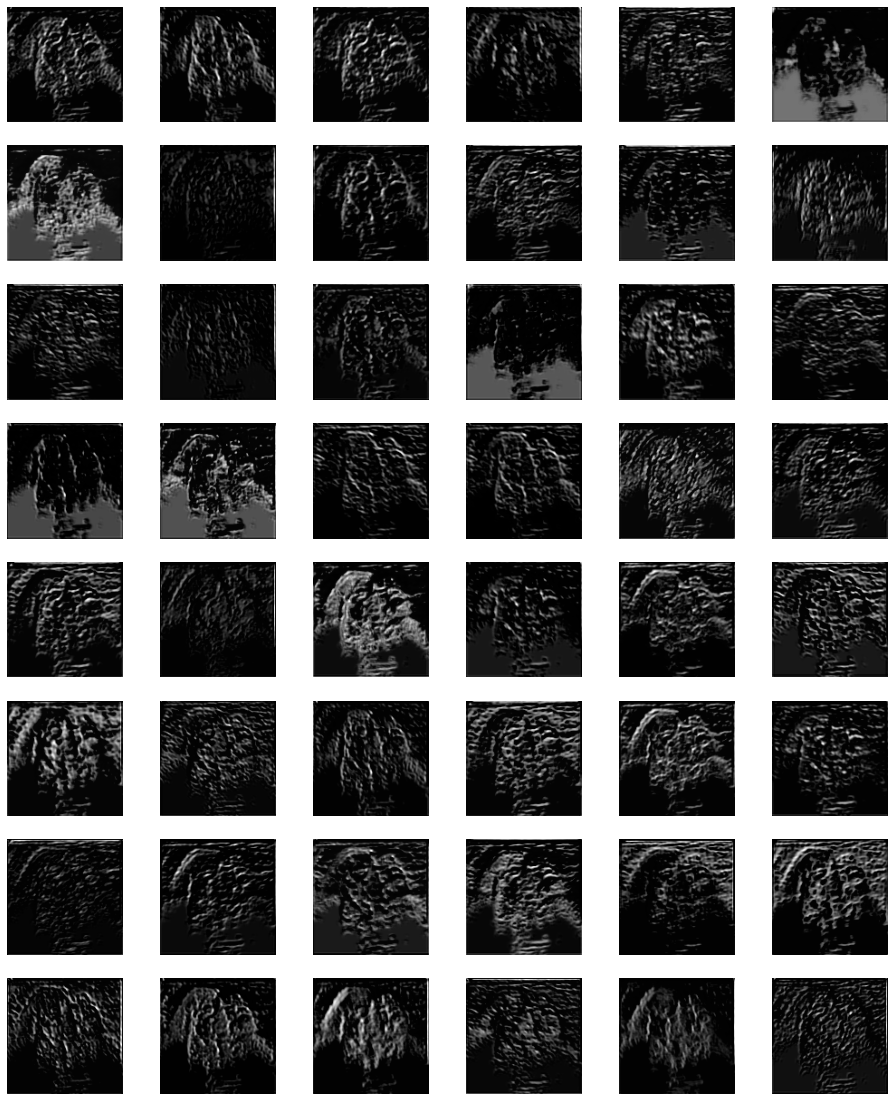

In [70]:
# Define the input image
sample = next(iter(test_loader))
input_image = sample['image'].to(dev)

# Get the activations of the first convolutional layer
encoder_1 = model.encoder1(input_image)
activations = model.encoder2(encoder_1)

# Convert the activations to a numpy array
# activations = torch.sigmoid(activations).detach().cpu().numpy()
activations = activations.detach().cpu().numpy()

# Visualize the activations
fig, axs = plt.subplots(8, 6, figsize=(16, 20))
for i in range(8):
    for j in range(6):
#         axs[i, j].imshow(activations[0, i*6+j, :, :] > 0.5, cmap='gray')
        axs[i, j].imshow(activations[0, i*6+j, :, :], cmap='gray')
        axs[i, j].axis('off')

# plt.subplots_adjust(wspace=-0.5, hspace=-0.5)
plt.show()

### Encoder 3

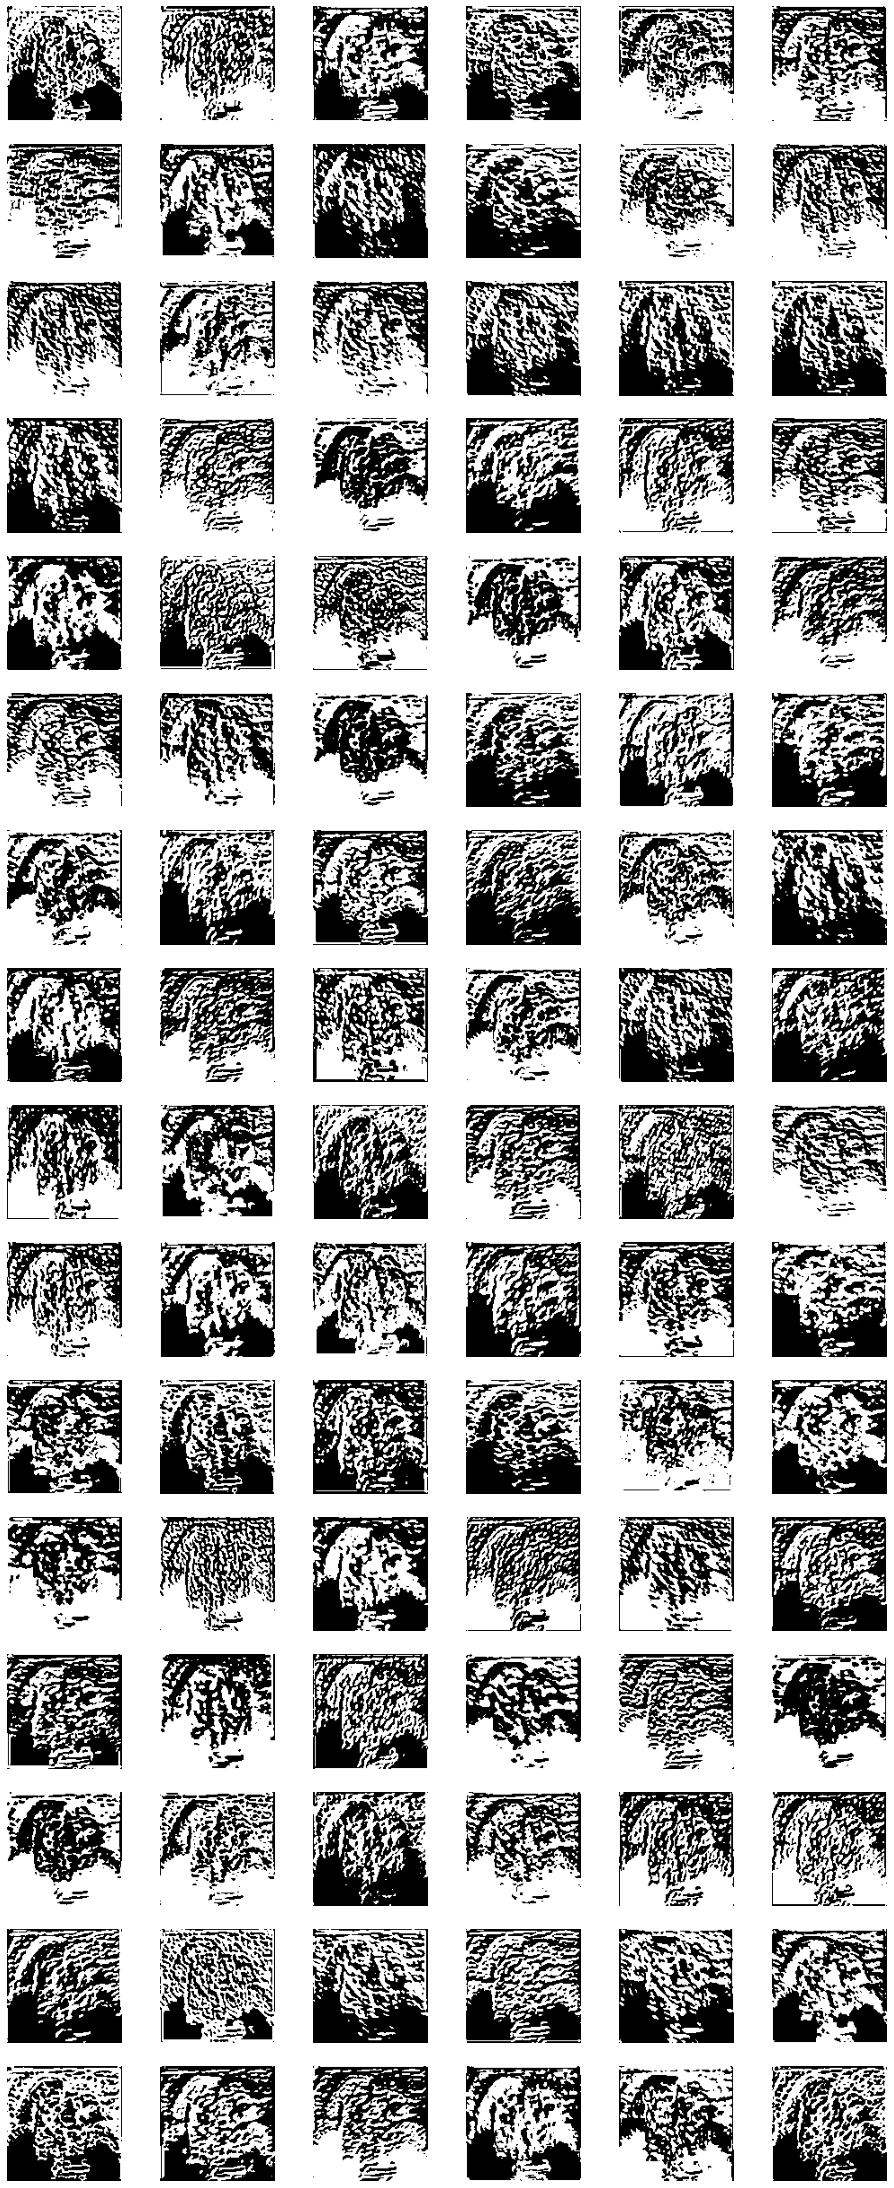

In [71]:
# Define the input image
sample = next(iter(test_loader))
input_image = sample['image'].to(dev)

# Get the activations of the first convolutional layer
encoder_1 = model.encoder1(input_image)
encoder_2 = model.encoder2(encoder_1)
activations = model.encoder3(encoder_2)

# Convert the activations to a numpy array
activations = torch.sigmoid(activations).detach().cpu().numpy()
# activations = activations.detach().cpu().numpy()

# Visualize the activations
fig, axs = plt.subplots(16, 6, figsize=(16, 40))
for i in range(16):
    for j in range(6):
        axs[i, j].imshow(activations[0, i*6+j, :, :] > 0.5, cmap='gray')
#         axs[i, j].imshow(activations[0, i*6+j, :, :], cmap='gray')
        axs[i, j].axis('off')

# plt.subplots_adjust(wspace=-0.5, hspace=-0.5)
plt.show()

## Saliency map

In [72]:
# Define the input image and label
sample = next(iter(test_loader))
input_image = sample['image'].to(dev)
input_image.requires_grad_()



tensor([[[[182., 205., 204.,  ..., 168.,   1.,   0.],
          [204., 199., 204.,  ..., 193., 147.,   0.],
          [  5.,   1.,   0.,  ..., 140., 123.,   1.],
          ...,
          [  1.,   1.,   1.,  ...,   1.,   1.,   1.],
          [  1.,   1.,   1.,  ...,   1.,   1.,   1.],
          [  1.,   1.,   1.,  ...,   1.,   1.,   1.]]]], device='cuda:0',
       requires_grad=True)

In [73]:
# Define the saliency map function
def get_saliency_map(model, input_image, target_class):
    # Set the model to evaluation mode
    model.eval()

    # Get the outputs at different layers of the network
    output3, output2, out_npl1, out_npl2, out_npl3, out_npl4, input1, output1 = model(input_image)

    # Compute the gradients for each output
    grad1 = torch.autograd.grad(torch.sigmoid(out_npl3)[:, target_class].sum(), input_image, create_graph=True)[0]
#     grad2 = torch.autograd.grad(output2[:, target_class].sum(), input_image, create_graph=True)[0]
#     grad3 = torch.autograd.grad(output3[:, target_class].sum(), input_image, create_graph=True)[0]

    # Compute the saliency maps for each output
    saliency1 = torch.abs(grad1).max(dim=1)[0]
#     saliency2 = torch.abs(grad2).max(dim=1)[0]
#     saliency3 = torch.abs(grad3).max(dim=1)[0]

    # Combine the saliency maps by taking the maximum pixel value across all maps at each location
    saliency_map = torch.max(torch.stack([saliency1]), dim=0)[0]
#     saliency_map = torch.max(torch.stack([saliency1, saliency2, saliency3]), dim=0)[0]

    # Normalize the saliency map
    saliency_map = saliency_map / saliency_map.max()

    # Convert the saliency map to a numpy array and return it
    return saliency_map.detach().cpu().numpy()

In [74]:
saliency_map = get_saliency_map(model, input_image, target_class=0)

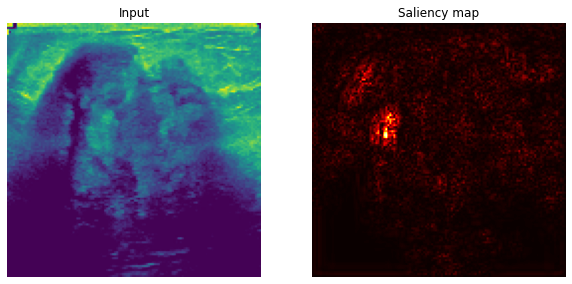

In [75]:
# Plot the input image and the saliency map
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.transpose(input_image[0].detach().cpu().numpy(), (1, 2, 0)))
axs[0].set_title('Input')
axs[0].axis('off')
axs[1].imshow(saliency_map[0, :, :], cmap=plt.cm.hot)
axs[1].set_title('Saliency map')
axs[1].axis('off')
plt.show()

## Visualizing filters

Filters in a convolutional neural network are used to extract specific features from the input image. Each filter is a set of weights that are learned during the training process to capture a specific pattern in the image.

In general, the first convolutional layers tend to capture low-level features such as edges, lines, and corners. As we move deeper into the network, the filters tend to capture more complex and abstract features. For example, in an image classification task, the final layers of the network might learn to recognize specific objects or even entire scenes.

By visualizing the filters, we can get an idea of what kind of features the network is learning. For example, if we see that certain filters are particularly good at capturing edges or corners, we can infer that the model is using these features as building blocks to recognize more complex shapes. If we see that certain filters are particularly activated in specific regions of the input image, we can infer that the model is attending to those regions in order to make its prediction.

In the context of image segmentation, visualizing filters can provide insights into what patterns or features the model is learning to identify for segmentation. By analyzing the learned filters, you can better understand what features are important for the model to identify and segment objects in the images.

For example, if you see that certain filters are activated when the model is identifying the edges or boundaries of an object, you can conclude that the model is using these edges as a key feature to segment the object from the background. Alternatively, if you see that certain filters are activated in regions with particular textures or shapes, this could suggest that the model is using these textures or shapes as features to identify and segment certain objects.

You can also use filter visualization to identify overfitting or underfitting. Overfitting happens when the model learns features that are specific to the training set and not generalizable to other data. This can be identified by looking for filters that are very specific to the training set and don't seem to have any meaningful patterns. Underfitting, on the other hand, happens when the model doesn't learn enough features to be able to generalize to new data. This can be identified by looking for filters that are very generic and don't seem to capture any meaningful patterns.

Overall, filter visualization can provide useful insights into how the model is processing the input images and can help guide further improvements in the model's architecture or training process.

### Encoder 1 - First block

(12, 1, 3, 3)


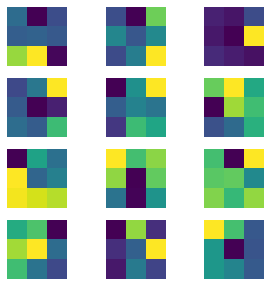

In [121]:
# Extract the first convolutional layer
encoder1 = model.encoder1.ConvInNormLRelu1.Conv
print(encoder1.weight.data.cpu().numpy().shape)

# Get the filter weights
filters = encoder1.weight.data.cpu().numpy()

# Plot the filters as images
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(5,5))
for i, ax in enumerate(axes.flat):
    ax.imshow(filters[i,:,:,:].transpose((1,2,0)))
    ax.axis('off')

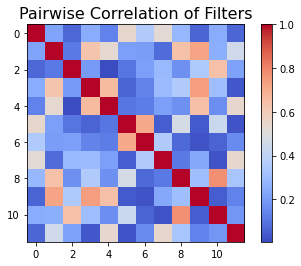

In [122]:
plot_correlations(filters)

### Encoder 1 - Second block

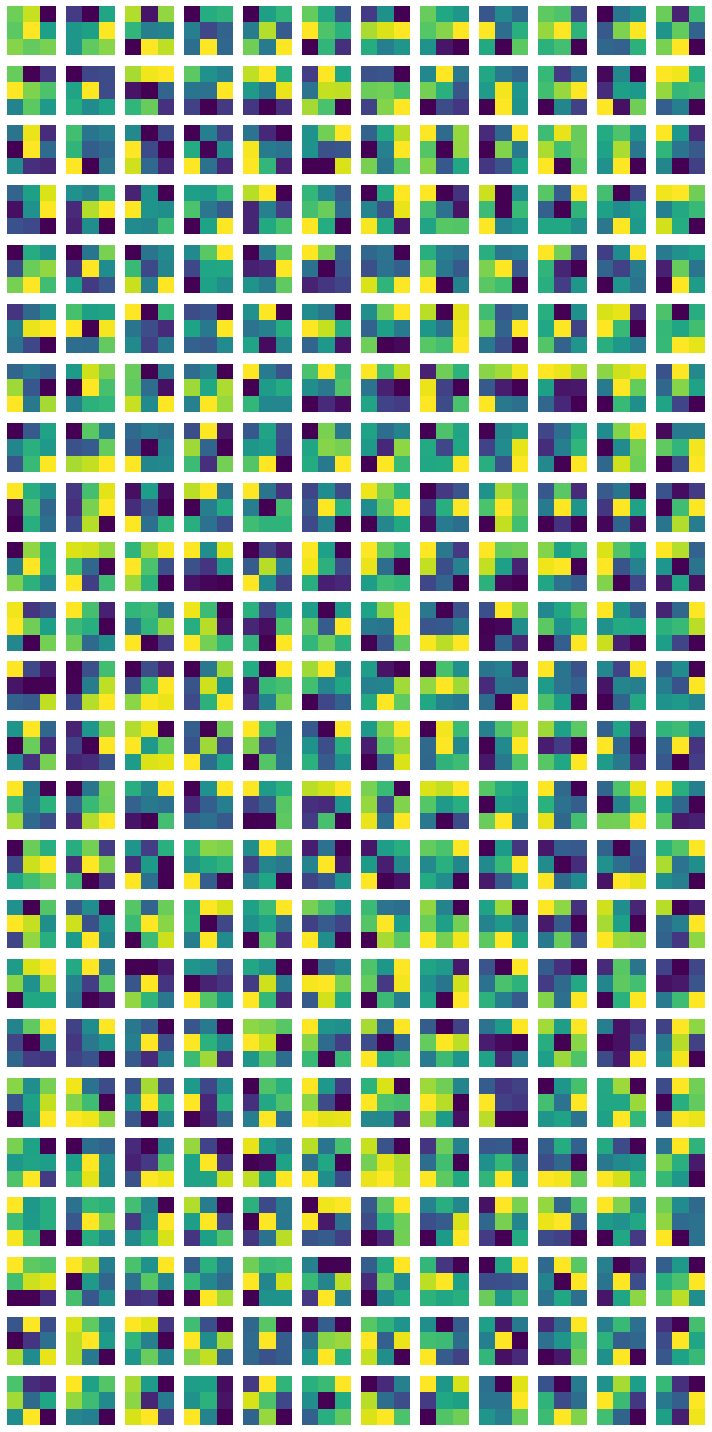

In [123]:
# Extract the first convolutional layer
conv_layer = model.encoder1.ConvInNormLRelu2.Conv

# Get the weight tensor from the convolutional layer
weight_tensor = conv_layer.weight.data.cpu().numpy()

# Get the number of filters and channels in the convolutional layer
num_filters, num_channels, filter_height, filter_width = weight_tensor.shape

# Create a figure with a subplot for each filter
fig, axs = plt.subplots(num_filters, num_channels, figsize=(10, 20))

# Loop over each filter and channel
for i in range(num_filters):
    for j in range(num_channels):
        # Extract the filter from the weight tensor
        filter = weight_tensor[i, j, :, :]

        # Normalize the filter so that its values range from 0 to 1
        filter = (filter - np.min(filter)) / (np.max(filter) - np.min(filter))

        # Plot the filter as an image in the corresponding subplot
        axs[i, j].imshow(filter)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
weight_tensor.shape

In [ ]:
plot_filter_correlations(weight_tensor)

### Decoder 1 - Second block

In [ ]:
# Extract the first convolutional layer
conv_layer = model.decoder1.ConvInNormLRelu2.Conv

# Get the weight tensor from the convolutional layer
weight_tensor = conv_layer.weight.data.cpu().numpy()

# Get the number of filters and channels in the convolutional layer
num_filters, num_channels, filter_height, filter_width = weight_tensor.shape

# Create a figure with a subplot for each filter
fig, axs = plt.subplots(num_filters, num_channels, figsize=(20, 10))

# Loop over each filter and channel
for i in range(num_filters):
    for j in range(num_channels):
        # Extract the filter from the weight tensor
        filter = weight_tensor[i, j, :, :]

        # Normalize the filter so that its values range from 0 to 1
        filter = (filter - np.min(filter)) / (np.max(filter) - np.min(filter))

        # Plot the filter as an image in the corresponding subplot
        axs[i, j].imshow(filter)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
plot_filter_correlations(weight_tensor)

# Test

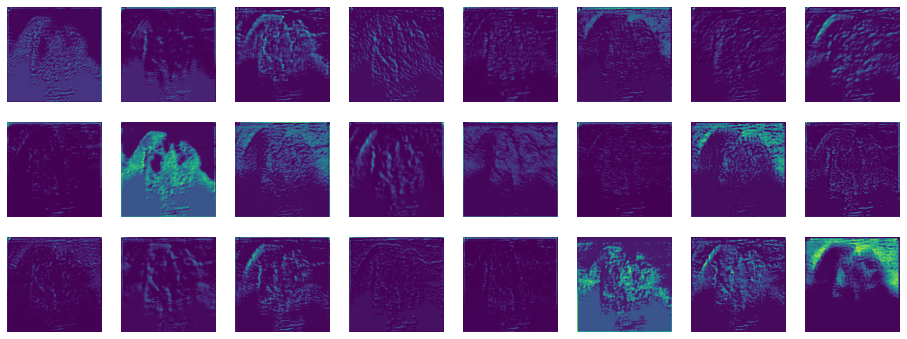

In [126]:
# Define the input image
sample = next(iter(test_loader))
input_image = sample['image'].to(dev)

# Get the activations of the first convolutional layer
activations = model.npl1(input_image)

# Convert the activations to a numpy array
activations = activations.detach().cpu().numpy()

# Visualize the activations
fig, axs = plt.subplots(3, 8, figsize=(16, 6))
for i in range(3):
    for j in range(8):
        axs[i, j].imshow(activations[0, i*8+j, :, :])
        axs[i, j].axis('off')

# plt.subplots_adjust(wspace=-0.5, hspace=-0.5)
plt.show()

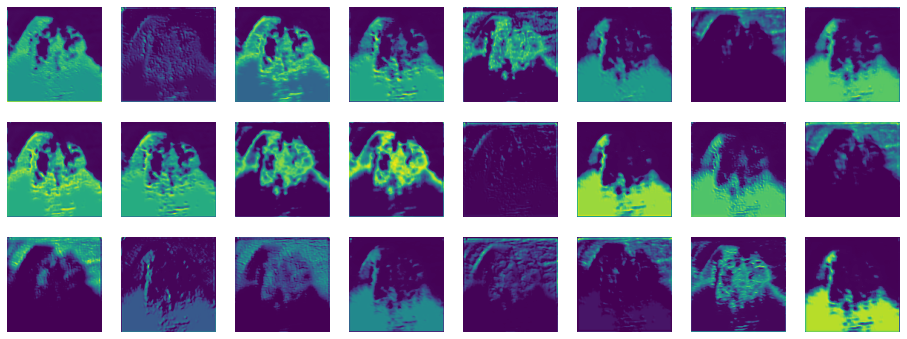

In [131]:
# Define the input image
sample = next(iter(test_loader))
input_image = sample['image'].to(dev)

# Get the activations of the first convolutional layer
npl1 = model.npl1(input_image)
activations = model.npl2(torch.concat([npl1, input_image], dim=1))

# Convert the activations to a numpy array
# activations = torch.sigmoid(activations).detach().cpu().numpy()
activations = activations.detach().cpu().numpy()

# Visualize the activations
fig, axs = plt.subplots(3, 8, figsize=(16, 6))
for i in range(3):
    for j in range(8):
        axs[i, j].imshow(activations[0, i*8+j, :, :])
        axs[i, j].axis('off')

# plt.subplots_adjust(wspace=-0.5, hspace=-0.5)
plt.show()

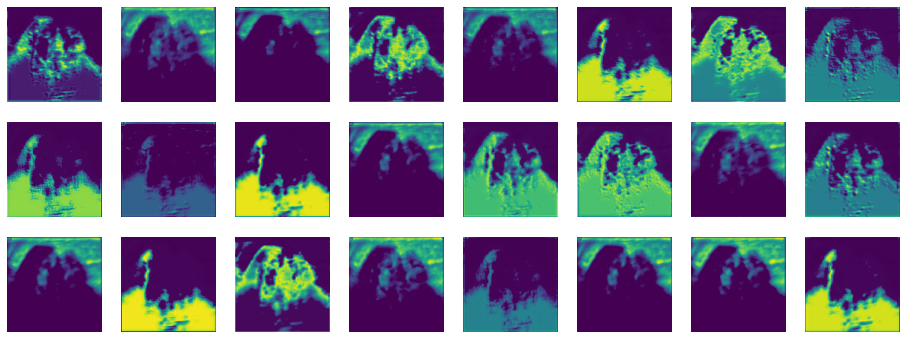

In [132]:
# Define the input image
sample = next(iter(test_loader))
input_image = sample['image'].to(dev)

# Get the activations of the first convolutional layer
npl1 = model.npl1(input_image)
npl2 = model.npl2(torch.concat([npl1, input_image], dim=1))
activations = model.npl3(torch.concat([npl2, input_image], dim=1))

# Convert the activations to a numpy array
# activations = torch.sigmoid(activations).detach().cpu().numpy()
activations = activations.detach().cpu().numpy()

# Visualize the activations
fig, axs = plt.subplots(3, 8, figsize=(16, 6))
for i in range(3):
    for j in range(8):
        axs[i, j].imshow(activations[0, i*8+j, :, :])
        axs[i, j].axis('off')

# plt.subplots_adjust(wspace=-0.5, hspace=-0.5)
plt.show()

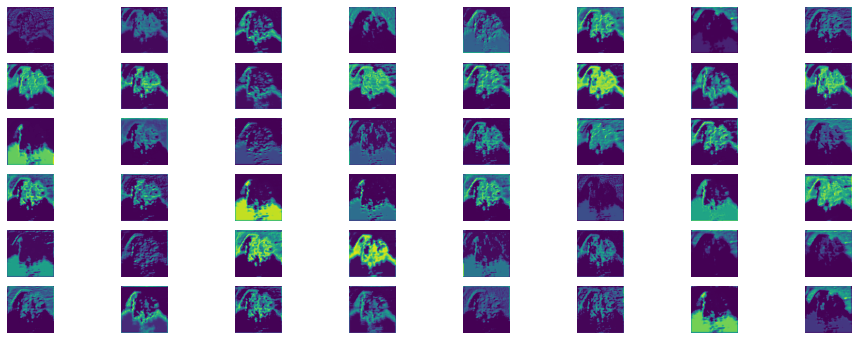

In [135]:
# Define the input image
sample = next(iter(test_loader))
input_image = sample['image'].to(dev)

# Get the activations of the first convolutional layer
npl1 = model.npl1(input_image)
npl2 = model.npl2(torch.concat([npl1, input_image], dim=1))
npl3 = model.npl3(torch.concat([npl2, input_image], dim=1))
activations = model.npl4(torch.concat([npl3, input_image], dim=1))

# Convert the activations to a numpy array
# activations = torch.sigmoid(activations).detach().cpu().numpy()
activations = activations.detach().cpu().numpy()

# Visualize the activations
fig, axs = plt.subplots(6, 8, figsize=(16, 6))
for i in range(6):
    for j in range(8):
        axs[i, j].imshow(activations[0, i*8+j, :, :])
        axs[i, j].axis('off')

# plt.subplots_adjust(wspace=-0.5, hspace=-0.5)
plt.show()

In [146]:
# Define the input image
sample = next(iter(test_loader))
input_image = sample['image'].to(dev)

e1 = model.encoder1(input_image)
p1 = model.downsample(e1)

e2 = model.encoder2(p1)
p2 = model.downsample(e2)

e3 = model.encoder3(p2)
p3 = model.downsample(e3)

e4 = model.encoder4(p3)


# Bottleneck phase
bottleneck = model.bottleneck(e4)

# Decoding phase + skip connections
d4 = model.decoder4(torch.cat([e4, bottleneck], dim=1))
up3 = model.upsample(d4)
d3 = model.decoder3(torch.cat([e3, up3], dim=1))
up2 = model.upsample(d3)
d2 = model.decoder2(torch.cat([e2, up2], dim=1))
up1 = model.upsample(d2)
d1 = model.decoder1(torch.cat([e1, up1, npl4], dim=1))


RuntimeError: Given groups=1, weight of size [96, 1152, 3, 3], expected input[1, 384, 16, 16] to have 1152 channels, but got 384 channels instead

1
(1, 24, 128, 128)


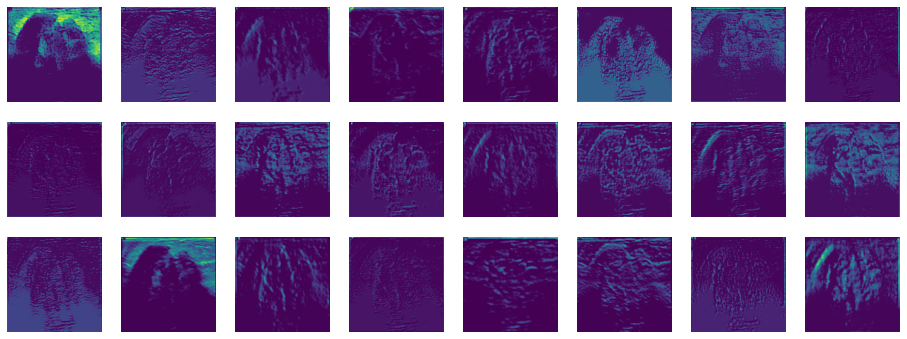

2
(1, 48, 64, 64)


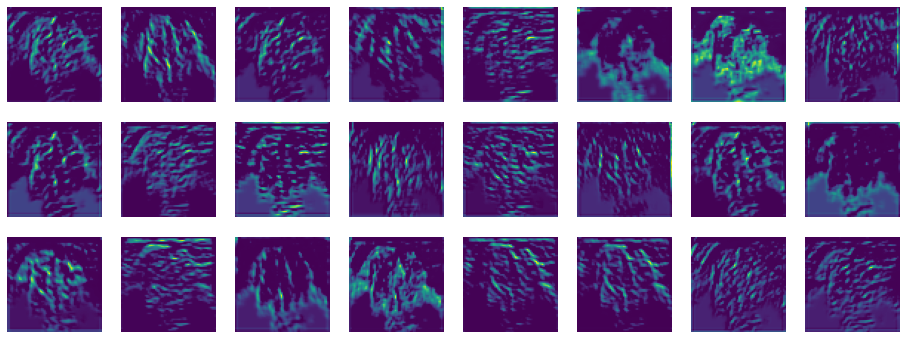

3
(1, 96, 32, 32)


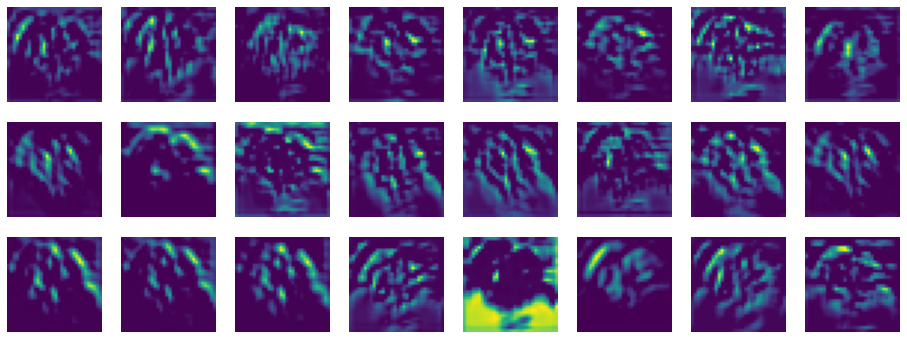

4
(1, 192, 16, 16)


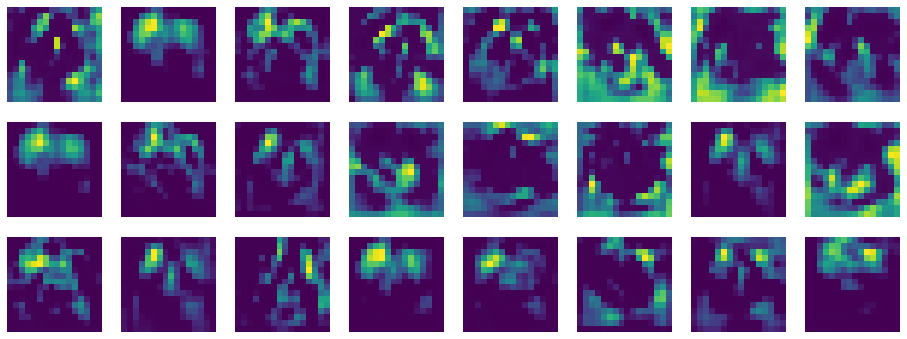

In [144]:
for k, l in enumerate([e1, e2, e3, e4]):
    print(k+1)
    activations = l.detach().cpu().numpy()
    print(activations.shape)
    # Visualize the activations
    fig, axs = plt.subplots(3, 8, figsize=(16, 6))
    for i in range(3):
        for j in range(8):
            axs[i, j].imshow(activations[0, i*8+j, :, :])
            axs[i, j].axis('off')

    # plt.subplots_adjust(wspace=-0.5, hspace=-0.5)
    plt.show()

In [147]:
os.listdir()

['Resultados',
 '.idea',
 'checks.py',
 'papers',
 'Datasets',
 'Results',
 'README.md',
 'runs',
 '.git',
 'notebooks',
 'src',
 '.gitignore']

In [151]:
for subdir, dirs, files in os.walk("./runs"):
    for file in files:
        print(os.path.join(subdir, file))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

